In [69]:
import torchaudio as ta
import torchaudio.transforms as T
import torch
import numpy as np
import yaml
# import mir_eval
import gc
import warnings
# from train import RTBWETrain
# from datamodule import *
from utils import *
from tqdm import tqdm
import wandb
import random
from torch.utils.data import Subset
import soundfile as sf
from datetime import datetime
import sys
import torch.nn.functional as F
import argparse

from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
# from SEANet_v2 import SEANet_ver2
from models.SEANet_TFiLM_nok import SEANet_TFiLM as SEANet_TFiLM_nok
from models.SEANet_TFiLM_nok_modified import SEANet_TFiLM as SEANet_TFiLM_nokmod

from MelGAN import Discriminator_MelGAN
from MBSTFTD import MultiBandSTFTDiscriminator

from dataset import CustomDataset

from models.SEANet_TFiLM import SEANet_TFiLM
from models.SEANet import SEANet
from IPython.display import display, Audio

def count_params(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000
    print(f"trainable_parms {trainable_params}M")

In [86]:
""" Load DataLoader """
""" 원본에 비해 fir 은 앞에 100을 crop 해야함 """
path_wb = [
            "/mnt/hdd/Dataset/FSD50K_48kHz/FSD50K.eval_audio", 
            "/mnt/hdd/Dataset/MUSDB18_HQ_mono_48kHz/test", 
            ]
path_nb = [
            "/mnt/hdd/FSD50K_CORE_fir/FSD50K.eval_audio", 
            "/mnt/hdd/MUSDB18_CORE_fir/test", 
            ]

dataset = CustomDataset(path_dir_nb=path_nb, path_dir_wb=path_wb, seg_len=1, mode="train")

""" Load Model """
# model = SEANet()
# path = "/home/woongjib/Projects/BESSL__/ckpt_baseline/epoch_5_lsdH_0.596.pth"

# # 64 model
model = SEANet_TFiLM(kmeans_model_path="/home/woongjib/Projects/BESSL__/kmeans/K64_MAE.pkl")
path = "/home/woongjib/Projects/BESSL__/ckpts/ckpt_BESSL_AAC13.5/ckpt_K64/epoch_41_lsdH_0.441.pth"

# # nok model
# model = SEANet_TFiLM_nok()
# path = "/home/woongjib/Projects/BESSL__/ckpts/ckpt_D64m_data/epoch_14_lsdH_0.367.pth"

## FT
model = SEANet_TFiLM_nokmod(in_channels=64)
path = "/home/woongjib/Projects/BESSL__/ckpts/ckpt_D64m_data/epoch_14_lsdH_0.367.pth"

ckpt = torch.load(path)
ckpt = ckpt['generator_state_dict']

model.load_state_dict(ckpt)

### Music Data
path_wb = [
            "/mnt/hdd/Dataset/MUSDB18_HQ_mono_48kHz/test", 
            ]
path_nb = [
            "/mnt/hdd/MUSDB18_CORE_fir/test", 
            ]

mus_dataset = CustomDataset(path_dir_nb=path_nb, path_dir_wb=path_wb, seg_len=1, mode="train",)

# no FT, scratch model
model2 = SEANet_TFiLM_nokmod(in_channels=64)
path = "/home/woongjib/Projects/BESSL__/ckpts/ckpt_D64m_data/epoch_15_lsdH_0.368.pth"

ckpt = torch.load(path)
ckpt = ckpt['generator_state_dict']
model2.load_state_dict(ckpt)

Index:0 with 10231 samples
Index:1 with 250 samples
LR 10481 and HR 10481 file numbers loaded!
train: 10481 files loaded


/home/woongjib/anaconda3/envs/env2/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Index:0 with 250 samples
LR 250 and HR 250 file numbers loaded!
train: 250 files loaded


<All keys matched successfully>

In [89]:
path_wb = [
            "/mnt/hdd/Dataset_BESSL/FSD50K_WB_SEGMENT/", 
            "/mnt/hdd/Dataset_BESSL/MUSDB_WB_SEGMENT/", 
            
            ]
path_nb = [
            "/mnt/hdd/Dataset_BESSL/FSD50K_LPF/", 
            "/mnt/hdd/Dataset_BESSL/MUSDB_LPF/", 
            
            ]
dataset = CustomDataset(path_dir_nb=path_nb, path_dir_wb=path_wb, seg_len=0.9, mode="train")


# """ nb에서 100을 crop 해야하는 이유 """
# path_wb = [
#             "/mnt/hdd/Dataset/FSD50K_48kHz/FSD50K.eval_audio", 
#             "/mnt/hdd/Dataset/MUSDB18_HQ_mono_48kHz/test", 
#             ]
# path_nb = [
#             "/mnt/hdd/FSD50K_CORE_fir/FSD50K.eval_audio", 
#             "/mnt/hdd/MUSDB18_CORE_fir/test", 
#             ]
# dataset = CustomDataset(path_dir_nb=path_nb, path_dir_wb=path_wb, seg_len=0.9, mode="train")

# # USAC Dataset, LPF must be cropped
# path_wb = ["/home/woongjib/Projects/USAC44_mono_48k"]
# path_nb = ["/home/woongjib/Projects/USAC44_mono_48k_HEAAC16_LPF_Crop"]
# dataset = CustomDataset(path_dir_nb=path_nb, path_dir_wb=path_wb, seg_len=1, mode="val")

print(283048*0.9/3600)
print(144773*0.9/3600)

Index:0 with 283048 samples
Index:1 with 144773 samples
LR 427821 and HR 427821 file numbers loaded!
train: 427821 files loaded
70.762
36.19325


254 100124_mono_segment_17


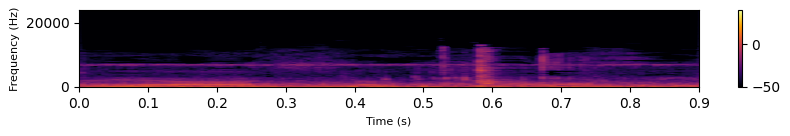

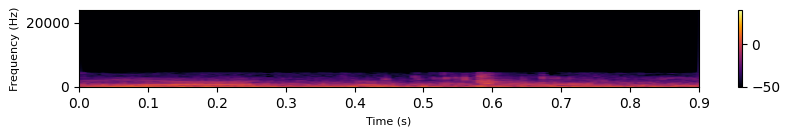

torch.Size([1, 43200]) torch.Size([1, 43200])


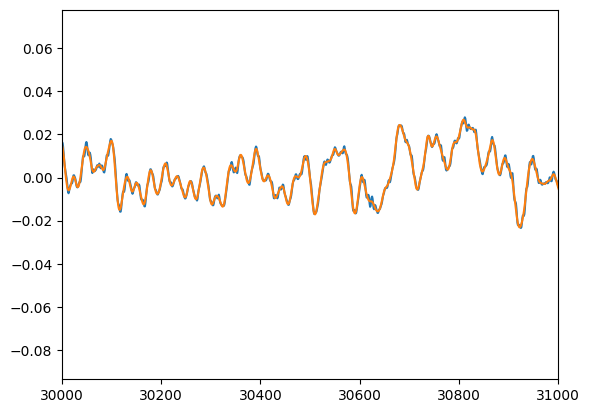

In [77]:
idx = torch.randint(1,300, (1,1))
idx = 254
wb, nb, spec, name, label = dataset[idx]
print(idx, name)
a = draw_spec(wb.squeeze().numpy(), sr=48000, figsize=(10,1))
a = draw_spec(nb.squeeze().numpy(), sr=48000, figsize=(10,1))
display(Audio(wb,rate=48000))
display(Audio(nb,rate=48000))

# nb = nb[:,100:]
plt.plot(wb.squeeze())
plt.plot(nb.squeeze())
plt.xlim(30000,31000)
# plt.xlim(43000,43200)
print(wb.shape, nb.shape)

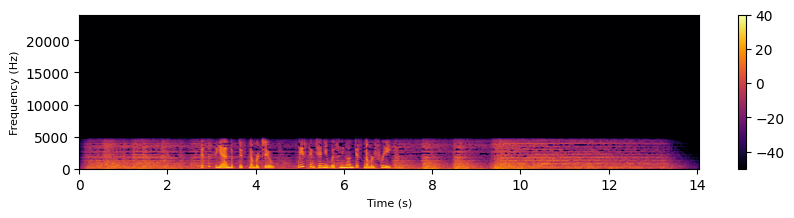

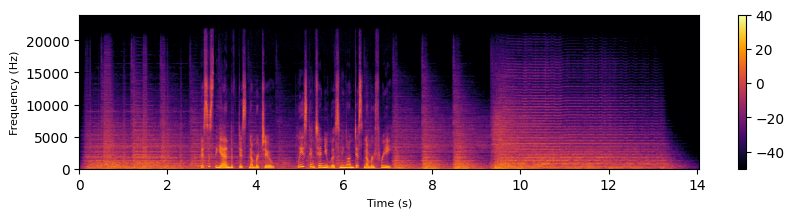

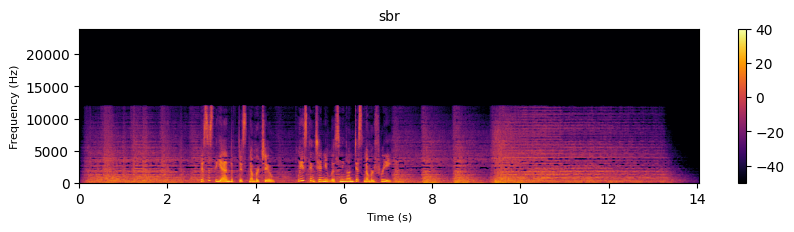

torch.Size([1, 674308]) 48000
torch.Size([1, 1025, 329])
4523.4375 24023.4375
torch.Size([1, 832, 329])
torch.Size([1, 1, 674308])


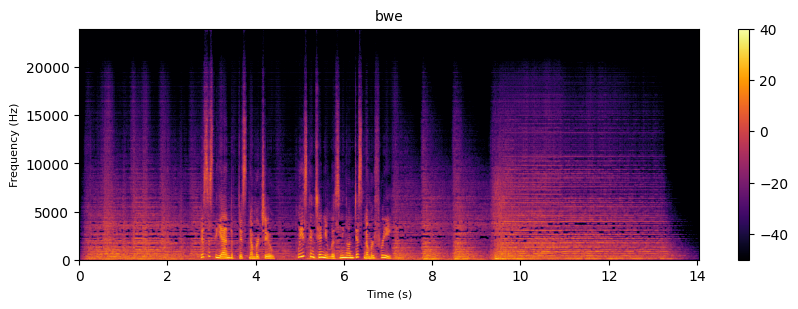

torch.Size([1, 674408]) torch.Size([1, 674308])


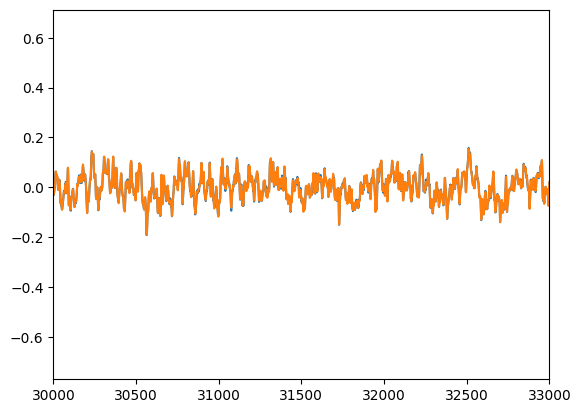

(1025, 2635)


In [79]:
def get_log_spectrogram(waveform):
    n_fft = 2048
    hop_length = 2048 
    win_length = 2048

    spectrogram = ta.transforms.Spectrogram(
        n_fft=n_fft, 
        hop_length=hop_length, 
        win_length=win_length, 
        power=2.0
    )(waveform)

    # return spectrogram[:, :]  
    log_spectrogram = ta.transforms.AmplitudeToDB()(spectrogram)
    spec_length = waveform.shape[-1] // 2048
    return log_spectrogram[..., :spec_length]  

def normalize_spec(spec):
    norm_mean = -42.61
    norm_std = 25.79
    spec = (spec - norm_mean) / (norm_std * 2)
    return spec

def extract_subband(spec, start=6, end=31):
    """ Get spectrogram Inputs and extract range of subbands : [start:end] """
    
    C,F,T = spec.shape
    num_subband = 32
    freqbin_size = F // num_subband
    dc_line = spec[:,0,:].unsqueeze(1)

    f_start = 1 + freqbin_size * start
    f_end = 1 + freqbin_size * (end+1)

    extracted_spec = spec[:,f_start:f_end,:]
    if f_start == 1:
        extracted_spec = torch.cat((dc_line, extracted_spec),dim=1)

    print(f_start/1024 * 24000, f_end/1024 * 24000)
    return extracted_spec
    
nb, sr = ta.load("/home/woongjib/Projects/USAC44_mono_48k_HEAAC16_LPF_Crop/Alice.wav")
nb = nb[:,100:]

wb, sr = ta.load("/home/woongjib/Projects/USAC44_mono_48k/Alice.wav")
a = draw_spec(nb.squeeze().numpy(), sr=48000, figsize=(10,2))
a = draw_spec(wb.squeeze().numpy(), sr=48000, figsize=(10,2))

sbr, _ = ta.load("/home/woongjib/Projects/USAC44_mono_48k_HEAAC16_Crop/Alice.wav")
a = draw_spec(sbr.squeeze().numpy(), sr=48000, figsize=(10,2), title='sbr')

print(nb.shape, sr)
spec = get_log_spectrogram(wb)
print(spec.shape)
spec = normalize_spec(spec)
spec = extract_subband(spec, end=31)

####
# spec = torch.zeros([1, 832, 268])
# spec = torch.zeros([1, 832, 329])
print(spec.shape) 

bwe = model2(nb, spec)
print(bwe.shape)
a = draw_spec(bwe.detach().squeeze().numpy(), sr=48000, figsize=(10,3),title='bwe')

# draw_spec((bwe-nb).detach().squeeze().numpy(), sr=48000, figsize=(10,3),title='bwenb')
# draw_spec((bwe-sbr[...,:-100]).detach().squeeze().numpy(), sr=48000, figsize=(10,3),title='bwesbr')
# draw_spec((nb-sbr[...,:-100]).detach().squeeze().numpy(), sr=48000, figsize=(10,3),title='nbsbr')

display(Audio(bwe.detach().squeeze().numpy(), rate=48000))
# display(Audio(bwe.detach().squeeze().numpy(), rate=48000))

plt.figure()
plt.plot(bwe.detach().squeeze().numpy())
plt.plot(sbr.detach().numpy().squeeze())
plt.xlim(30000,33000)
# plt.xlim(43000,43200)
print(wb.shape, nb.shape)
plt.show()

print(a.shape)








tensor([[119837]])
253672_mono_segment_1


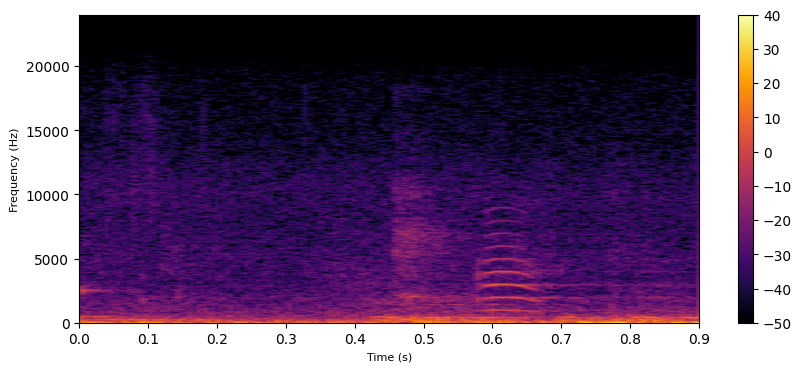

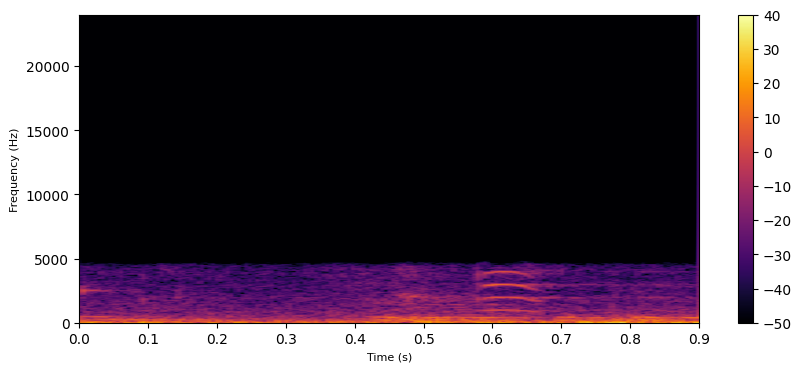

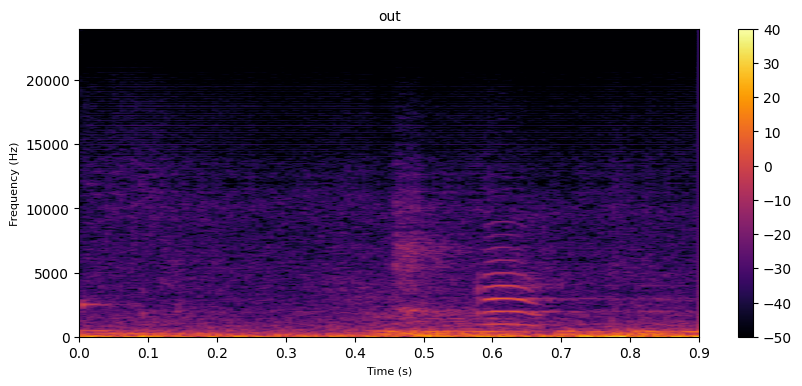

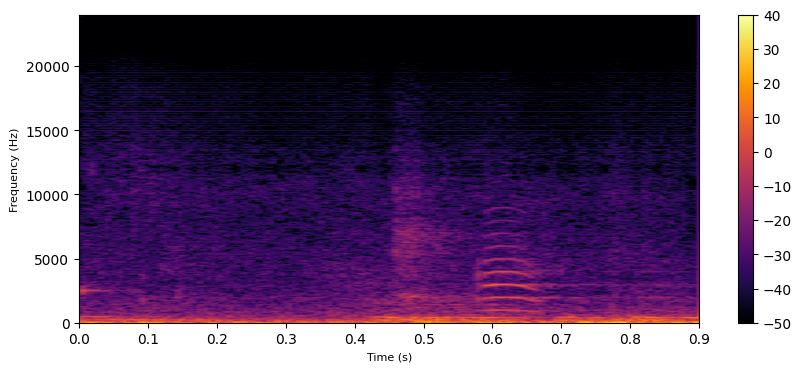

In [91]:
idx = torch.randint(80000,130000,size=(1,1))
print(idx)
# idx = 625
# idx = 11, 231, 757, 625, 1566, 805, 962, 1542, 2715, 1855
wb, nb, spec, name, label = dataset[idx]


# wb, nb, spec, name, label = mus_dataset[idx]
print(name)

# wb = wb[:, :-100]
# nb = nb[:, 100:]

a = draw_spec(wb.squeeze().numpy(), sr=48000, figsize=(10,4))
a = draw_spec(nb.squeeze().numpy(), sr=48000, figsize=(10,4))
display(Audio(wb, rate=48000))
# display(Audio(nb, rate=48000))

with torch.no_grad():
    out = model(nb, spec)
    out2 = model2(nb, spec)

a = draw_spec(out.squeeze().numpy(), sr=48000, figsize=(10,4), title='out')
display(Audio(out.squeeze().numpy(), rate=48000))

a = draw_spec(out2.squeeze().numpy(), sr=48000, figsize=(10,4))
display(Audio(out2.squeeze().numpy(), rate=48000))
display(Audio(nb.squeeze().numpy(), rate=48000))

